# **Land Cover Classification**

### **Load Required Libraries**

In [240]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import geopandas as gpd
import json
import rasterio as rio
from PIL import ImageColor

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### **Load Dataset**

In [241]:
lc_dir = 'lc.json'
raster_dir = 'rasters/s2images.tif'
points_dir = 'shapefiles/points.geojson'

In [242]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

,palette,values,label,values_normalize
0,#228B22,2002,Secondary dryland forest,1
1,#90EE90,2007,Dry shrub,2
2,#F08080,2012,Settlement,3
3,#87CEFA,5001,Open water,4
4,#6A5ACD,20041,Secondary mangrove forest,5
5,#66CDAA,20071,Wet shrub,6
6,#FFD700,20091,Pure dry agriculture,7
7,#FFA500,20092,Mixed dry agriculture,8
8,#008080,20093,Paddy field,9
9,#A0522D,20141,Mining,10


>- Note: The decription of each land cover class can be found in **the Regulation of the Director General of Forestry Planning Number: P.1/VII-IPSDH/2015 concerning Guidelines for Monitoring Land Cover**.

**Load Sentinel-2 Images**

In [243]:
s2 = rio.open(raster_dir)
s2_image = s2.read() / 1e4

**Load Sample Shapefile**

In [244]:
sample = gpd.read_file(points_dir)
sample['lc'] = sample['lc'].astype(str)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

### **Visualize Sample Data**

The Area of Interest (AoI) is located in Ketapang District, West Kalimantan, Indonesia, with satellite imagery captured on August 9, 2020.

(206, 6)


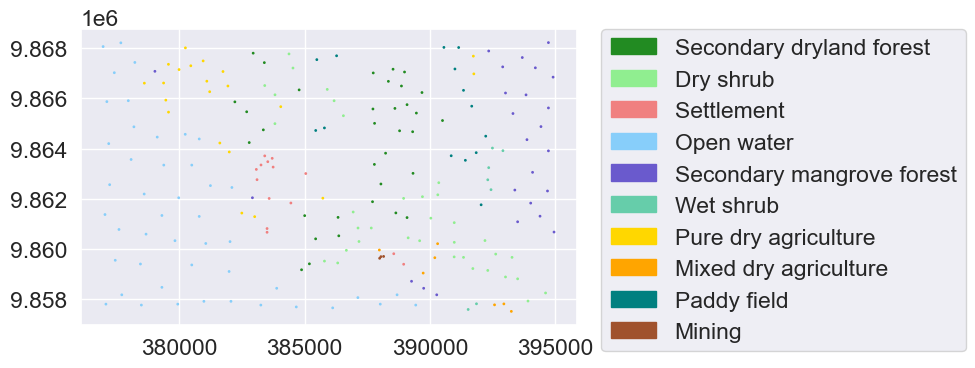

In [245]:
# Plot sample
sample.plot(column="value", cmap=cmap, markersize=1)
plt.legend(**legend)

sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)

### **Visualize Raster Data**

**Sentinel-2 Bands and Resolutions**

| Band Number | Central Wavelength (nm) | Description | Spatial Resolution (m) |
| --- | --- | --- | --- |
| Band 1 | 443 | Coastal Aerosol | 60 |
| Band 2 | 490 | Blue | 10 |
| Band 3 | 560 | Green | 10 |
| Band 4 | 665 | Red | 10 |
| Band 5 | 705 | Red Edge 1 | 20 |
| Band 6 | 740 | Red Edge 2 | 20 |
| Band 7 | 783 | Red Edge 3 | 20 |
| Band 8 | 842 | Near Infrared (NIR) | 10 |
| Band 8A | 865 | Narrow NIR | 20 |
| Band 9 | 945 | Water Vapour Absorption | 60 |
| Band 10 | 1375 | Cirrus | 60 |
| Band 11 | 1610 | SWIR 1 | 20 |
| Band 12 | 2190 | SWIR 2 | 20 |

Out of its 13 spectral bands, only 7 bands will used for the analysis, specifically those capturing **RGB (Red, Green, Blue)** and **NIR (Near-Infrared)** wavelengths.

In [246]:
blue = s2_image[0, :, :]  
green = s2_image[1, :, :]  
red = s2_image[2, :, :] 
nir = s2_image[6, :, :] 
ndvi = s2_image[7, :, :] 

**NDVI Ranges Values and Their Interpretation**

NDVI (Normalized Difference Vegetation Index) is one of vegetation indices that commonly used to measure egetation health and density. Its values range from -1 to +1, where higher values indicate healthier and denser vegetation. The formula to calculate NDVI is as follows::

NDVI = (NIR - RED)/ (NIR+RED)

| NDVI | Desciption |
| --- | --- |
| -1.0 to -0.1 | Water bodies |
| -0.1 to 0.0 | Bare soil, rocks, or impervious surfaces |
| 0.0 to 0.2 | Sparse vegetation or unhealthy vegetation |
| 0.2 to 0.4 | Shrublands, grasslands, or dry vegetation |
| 0.4 to 0.6 | Moderate vegetation cover |
| 0.6 to 0.8 | Dense vegetation |
| 0.8 to 1.0 | Very dense and healthy vegetation |

**Natural and False Color Composite**

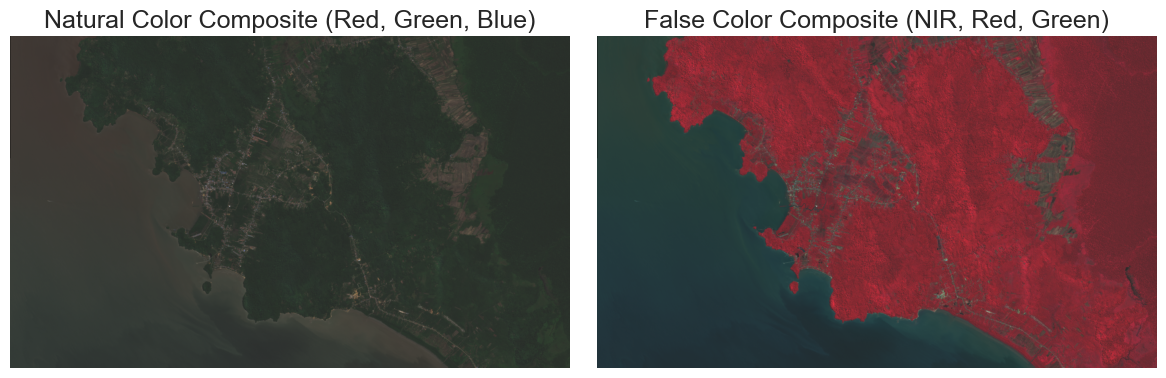

In [ ]:
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

# Normalize RGB bands
red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

# Normalize NIR 
nir_norm = normalize_band(nir)

# Create Natural and False Color Composite Images
rgb = np.dstack((red_norm, green_norm, blue_norm))
fcc = np.dstack((nir_norm, red_norm, green_norm)) 

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Natural Color Composite Image
axs[0].imshow(rgb)
axs[0].set_title("Natural Color Composite (Red, Green, Blue)")
axs[0].axis("off")

# False Color Composite Image
axs[1].imshow(fcc)
axs[1].set_title("False Color Composite (NIR, Red, Green)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

- **Natural Color Composite**: A natural color composite uses the red, green, and blue bands of satellite imagery to display features as they appear to the human eye, making it ideal for realistic visualization of landscapes and urban areas.
- **False Color Composite**: A false color composite utilizes non-visible bands like near-infrared, red, and green to enhance specific features, such as highlighting vegetation health or distinguishing water bodies.

**Normalized Difference Vegetation Index (NDVI)**

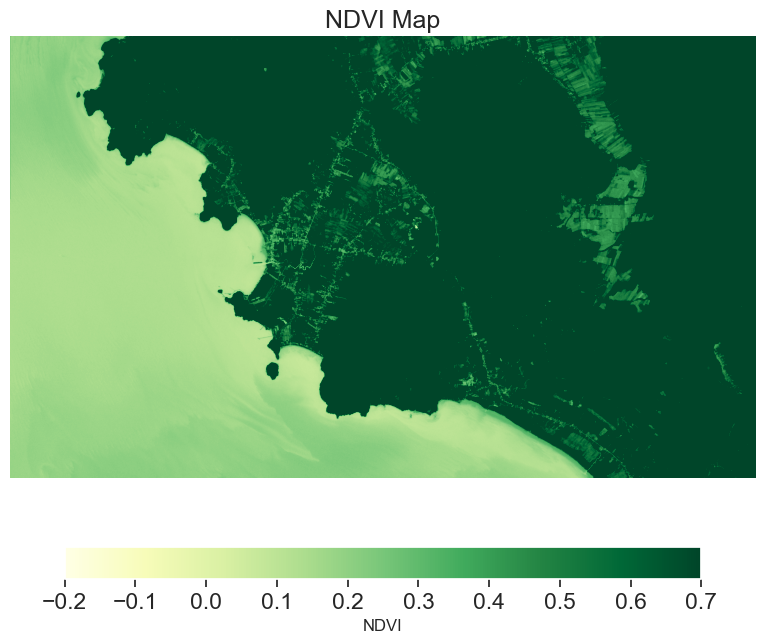

In [ ]:
# Normalize NDVI values
ndvi_norm = normalize_band(ndvi)

# Define NDVI colormap
ndvi_cmap = plt.cm.YlGn  
ndvi_min, ndvi_max = -0.2, 0.7  

# Create a new figure for NDVI
fig, ax = plt.subplots(figsize=(8, 8))  

# NDVI Image
ndvi_plot = ax.imshow(ndvi_norm, cmap=ndvi_cmap, vmin=ndvi_min, vmax=ndvi_max)
ax.set_title("NDVI Map")
ax.axis("off")

# Add a horizontal colorbar for NDVI
cbar = plt.colorbar(ndvi_plot, ax=ax, orientation="horizontal", fraction=0.046, pad=0.1)
cbar.set_label("NDVI", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Extract raster values
all_bands = np.stack([x for x in s2.sample(coords)])
reflectance_bands = all_bands[:, :-1] / 1e4  # Divide all bands except NDVI by 1e4
ndvi_band = all_bands[:, -1]  

# Assign reflectance bands to the DataFrame
sample_extract[["B2", "B3", "B4", "B5", "B6", "B7", "B8"]] = reflectance_bands

# Assign NDVI directly to the DataFrame
sample_extract["NDVI"] = ndvi_band

sample_extract

,id,lc,code,geometry,value,label,B2,B3,B4,B5,B6,B7,B8,NDVI
0,1,20093,Sw,POINT (391338.97 9866322.653),9,Paddy field,0.1451,0.1668,0.1638,0.2235,0.2917,0.3040,0.3374,0.346369
1,2,20093,Sw,POINT (391667.204 9865689.458),9,Paddy field,0.1470,0.1664,0.1718,0.2186,0.2758,0.2999,0.2936,0.261710
2,3,20093,Sw,POINT (386273.316 9867700.809),9,Paddy field,0.1244,0.1705,0.1239,0.2144,0.4593,0.5412,0.5516,0.633161
3,4,20093,Sw,POINT (390556.773 9868036.036),9,Paddy field,0.1330,0.1536,0.1472,0.1951,0.3314,0.3650,0.3568,0.415873
4,5,20093,Sw,POINT (391413.465 9863529.094),9,Paddy field,0.1532,0.1774,0.1780,0.2323,0.2985,0.3278,0.3526,0.329061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,202,5001,A,POINT (382094.617 9862444.262),4,Open water,0.1560,0.1746,0.1732,0.1702,0.1301,0.1328,0.1245,-0.163588
202,203,5001,A,POINT (379301.058 9861326.838),4,Open water,0.1540,0.1674,0.1619,0.1552,0.1281,0.1303,0.1255,-0.126653
203,204,5001,A,POINT (380790.956 9864381.13),4,Open water,0.1535,0.1714,0.1744,0.1710,0.1291,0.1311,0.1232,-0.172043
204,205,5001,A,POINT (389432.366 9857751.083),4,Open water,0.1604,0.1800,0.1834,0.1813,0.1398,0.1432,0.1346,-0.153459


### **Define X and Y**

In [226]:
x = sample_extract[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'NDVI']]
Y = sample_extract['value']

In [227]:
print(x.shape)  # Should be (n_samples, n_features)
print(Y.shape)

(206, 8)
(206,)


### **Data Splitting**

In [228]:
# Split sample to train and test
seeds = 2
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, train_size=0.7, random_state=seeds, stratify=Y)
print(f'Train size: {len(x_train)}\nTest size: {len(x_test)}')

Train size: 144
Test size: 62


### **Modeling**

In [238]:
# Define model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(x_train, Y_train)

RandomForestClassifier(random_state=42)

### **Evaluation**

In [239]:
# Make predictions on the test set
rf_model_pred = rf_model.predict(x_test)

# Evaluate the model
print(classification_report(Y_test, rf_model_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.62      0.80      0.70        10
           2       0.33      0.27      0.30        11
           3       0.00      0.00      0.00         4
           4       1.00      1.00      1.00        14
           5       0.80      1.00      0.89         8
           6       1.00      0.50      0.67         2
           7       0.33      0.50      0.40         6
           8       0.00      0.00      0.00         2
           9       1.00      0.25      0.40         4
          10       0.33      1.00      0.50         1

    accuracy                           0.63        62
   macro avg       0.54      0.53      0.49        62
weighted avg       0.62      0.63      0.60        62



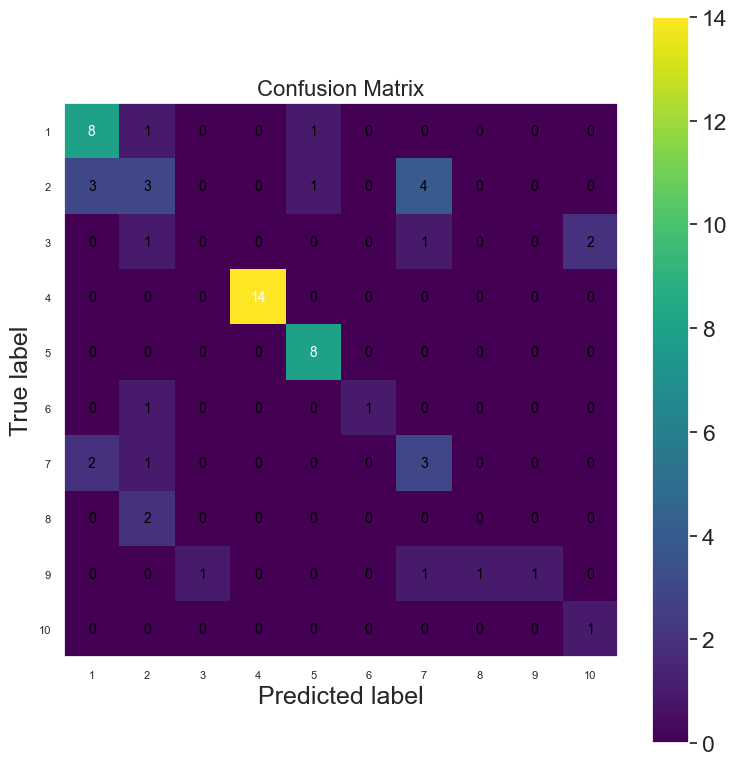

In [ ]:
# Compute confusion matrix 
cm = confusion_matrix(Y_test, rf_model_pred)

# Display the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Customize the plot
fig, ax = plt.subplots(figsize=(8, 8))  
display.plot(
    cmap="viridis",
    values_format="d",  
    ax=ax,
    colorbar=True
)

# Remove the grid 
ax.grid(False)

# Adjust tick labels for better readability
ax.set_xticks(np.arange(len(rf_model.classes_)))
ax.set_yticks(np.arange(len(rf_model.classes_)))
ax.set_xticklabels(rf_model.classes_, fontsize=8)
ax.set_yticklabels(rf_model.classes_, fontsize=8)

# Adjust text for better readability
for text in ax.texts:
    text.set_size(10) 
    text.set_color("white" if float(text.get_text()) > cm.max() / 2 else "black")  

# Add a title
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

### **Apply the Model to the Raster Images**

In [233]:
image_transpose = s2_image.transpose(1, 2, 0)  # Shape: (height, width, bands)
transpose_shape = image_transpose.shape

# Create a DataFrame from the Sentinel-2 image
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B2", "B3", "B4", "B5", "B6", "B7", "B8", "NDVI"]
)

# Display the DataFrame
print(table_image)

             B2      B3      B4   B5   B6   B7      B8      NDVI
0        0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.000000
1        0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.000000
2        0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.000000
3        0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.000000
4        0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.000000
...         ...     ...     ...  ...  ...  ...     ...       ...
2095080  0.1305  0.1558  0.1378  0.0  0.0  0.0  0.3546  0.000044
2095081  0.1301  0.1534  0.1381  0.0  0.0  0.0  0.3574  0.000044
2095082  0.1297  0.1590  0.1360  0.0  0.0  0.0  0.3846  0.000048
2095083  0.1287  0.1646  0.1356  0.0  0.0  0.0  0.4272  0.000052
2095084  0.1306  0.1628  0.1378  0.0  0.0  0.0  0.3930  0.000048

[2095085 rows x 8 columns]


In [234]:
# Define the feature columns (the ones used during training)
predictors = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "NDVI"]

# Ensure that the feature columns exist in table_image
assert all(col in table_image.columns for col in predictors), "Some feature columns are missing from table_image"

# Predict using the trained model
prediction = rf_model.predict(table_image[predictors])

# Display the predictions
print(prediction)

[4 4 4 ... 4 4 4]


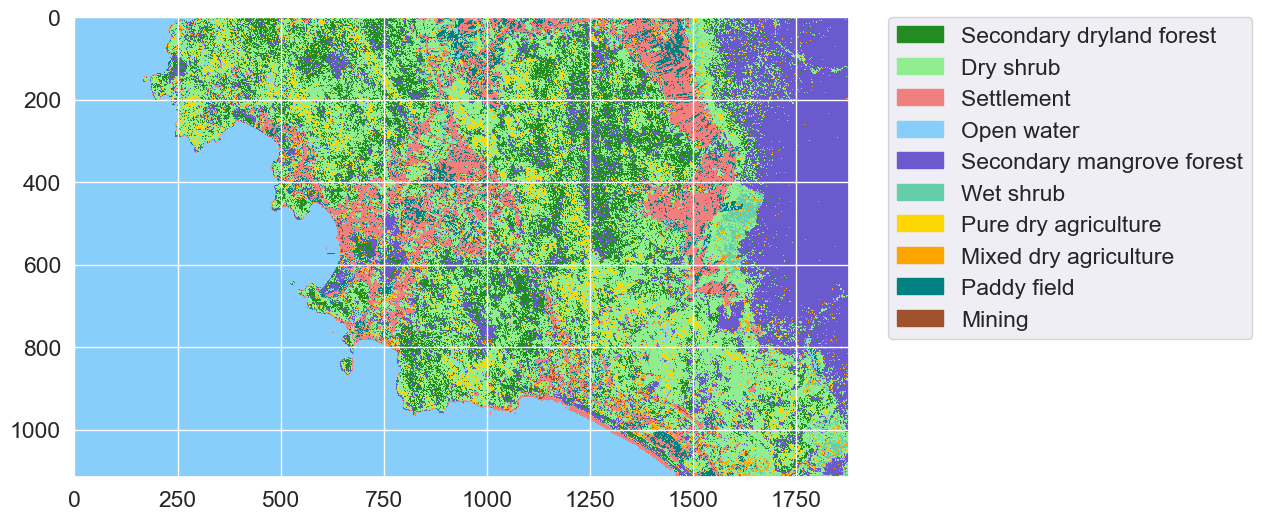

In [235]:
prediction_image = prediction.reshape(transpose_shape[0], transpose_shape[1]) 

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

### **Saving the Result**

In [236]:
# Save image to geotiff
output = rio.open(
    "rasters/LULC.tif",
    "w",
    "COG",
    count=1,
    width=prediction_image.shape[1],
    height=prediction_image.shape[0],
    crs=s2.crs,
    transform=s2.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(prediction_image, 1)
output.close()

Warning 6: driver COG does not support creation option TILED
